# Denoising CNN Autoencoder

In this notebook, we'll try and build an autoencoder CNN with the Keras library. An autoencoder is just a CNN the compresses the input into a smaller representation, and then tries to reconstruct the original input from the compressed representation. The idea is that the network will learn to extract the most important features of the input, and then use those features to reconstruct the input.

![Image Description](https://miro.medium.com/v2/resize:fit:1200/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

- First, we'll do some data exploration and cleaning
- Second, we'll build our simple autoencoder and check how it performs
- Third, we'll try to see how much better OCR (Optical Character Recognition) performs on the denoised images 
###
###

## Imports, downloads and unpack the dataset

If you want to run this, you just need to have your kaggle.json file in the same folder as this notebook. You can get it from your kaggle account settings.

You should also probably create a pyenv or virtualenv with the following packages installed.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import zipfile
from PIL import Image
import pytesseract
import tensorflow as tf
from tensorflow import keras 
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose

In [7]:
json_path = 'kaggle.json'

with open(json_path, 'r') as json_file:
    kaggle_credentials = json.load(json_file)

# Set the Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

In [8]:
!kaggle competitions download -c denoising-dirty-documents

denoising-dirty-documents.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
files = ['denoising-dirty-documents.zip', 'test.zip', 'train.zip', 'train_cleaned.zip']

for file in files:
    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('.')

In [10]:
# create directories for the project if they don't exist
if not os.path.exists('train_cleaned_resized'): os.mkdir('train_cleaned_resized') # y_train_resized
if not os.path.exists('train_resized'): os.mkdir('train_resized') # y_train
if not os.path.exists('test_resized'): os.mkdir('test_resized') # X_test_resized

# Data Exploration

## Store images path into lists

In [11]:
train_images, test_images, cleaned_images = list(), list(), list()

train_images = [os.path.join('train', image) for image in os.listdir('train')]
test_images = [os.path.join('test', image) for image in os.listdir('test')]
cleaned_images = [os.path.join('train_cleaned', image) for image in os.listdir('train_cleaned')]

In [12]:
train_images[0], test_images[0], cleaned_images[0]

('train/176.png', 'test/88.png', 'train_cleaned/176.png')

### Process images and check all different sizes in the dataset

In [13]:
def get_different_sizes(images):
    different_sizes = set()
    for image in images:
        img = plt.imread(image)
        different_sizes.add(img.shape)
    return different_sizes

train_different_sizes = get_different_sizes(train_images)
cleaned_different_sizes = get_different_sizes(cleaned_images)
test_different_sizes = get_different_sizes(test_images)

print(train_different_sizes)
print(cleaned_different_sizes)
print(test_different_sizes)


{(420, 540), (258, 540)}
{(420, 540), (258, 540)}
{(420, 540), (258, 540)}


In [14]:
small_size = (258, 540)
big_size = (420, 540)

def count_images(images, small_size, big_size):
    count_small, count_big = 0, 0

    for image in images:
        img = plt.imread(image)
        if img.shape == small_size:
            count_small += 1
        elif img.shape == big_size:
            count_big += 1
    return count_small, count_big

X_train_counts = count_images(train_images, small_size, big_size)
y_train_counts = count_images(cleaned_images, small_size, big_size)
X_test_counts = count_images(test_images, small_size, big_size)

column_names = ['small_img', 'big_img']
row_labels = ['X_train', 'y_train', 'X_test']

counts_matrix = [X_train_counts, y_train_counts, X_test_counts]

df = pd.DataFrame(counts_matrix, columns=column_names, index=row_labels)
df


small_img  big_img
X_train         48       96
y_train         48       96
X_test          24       48

Ok so we got twice as much big images as we got small ones, and we get the same distribution in all our sets

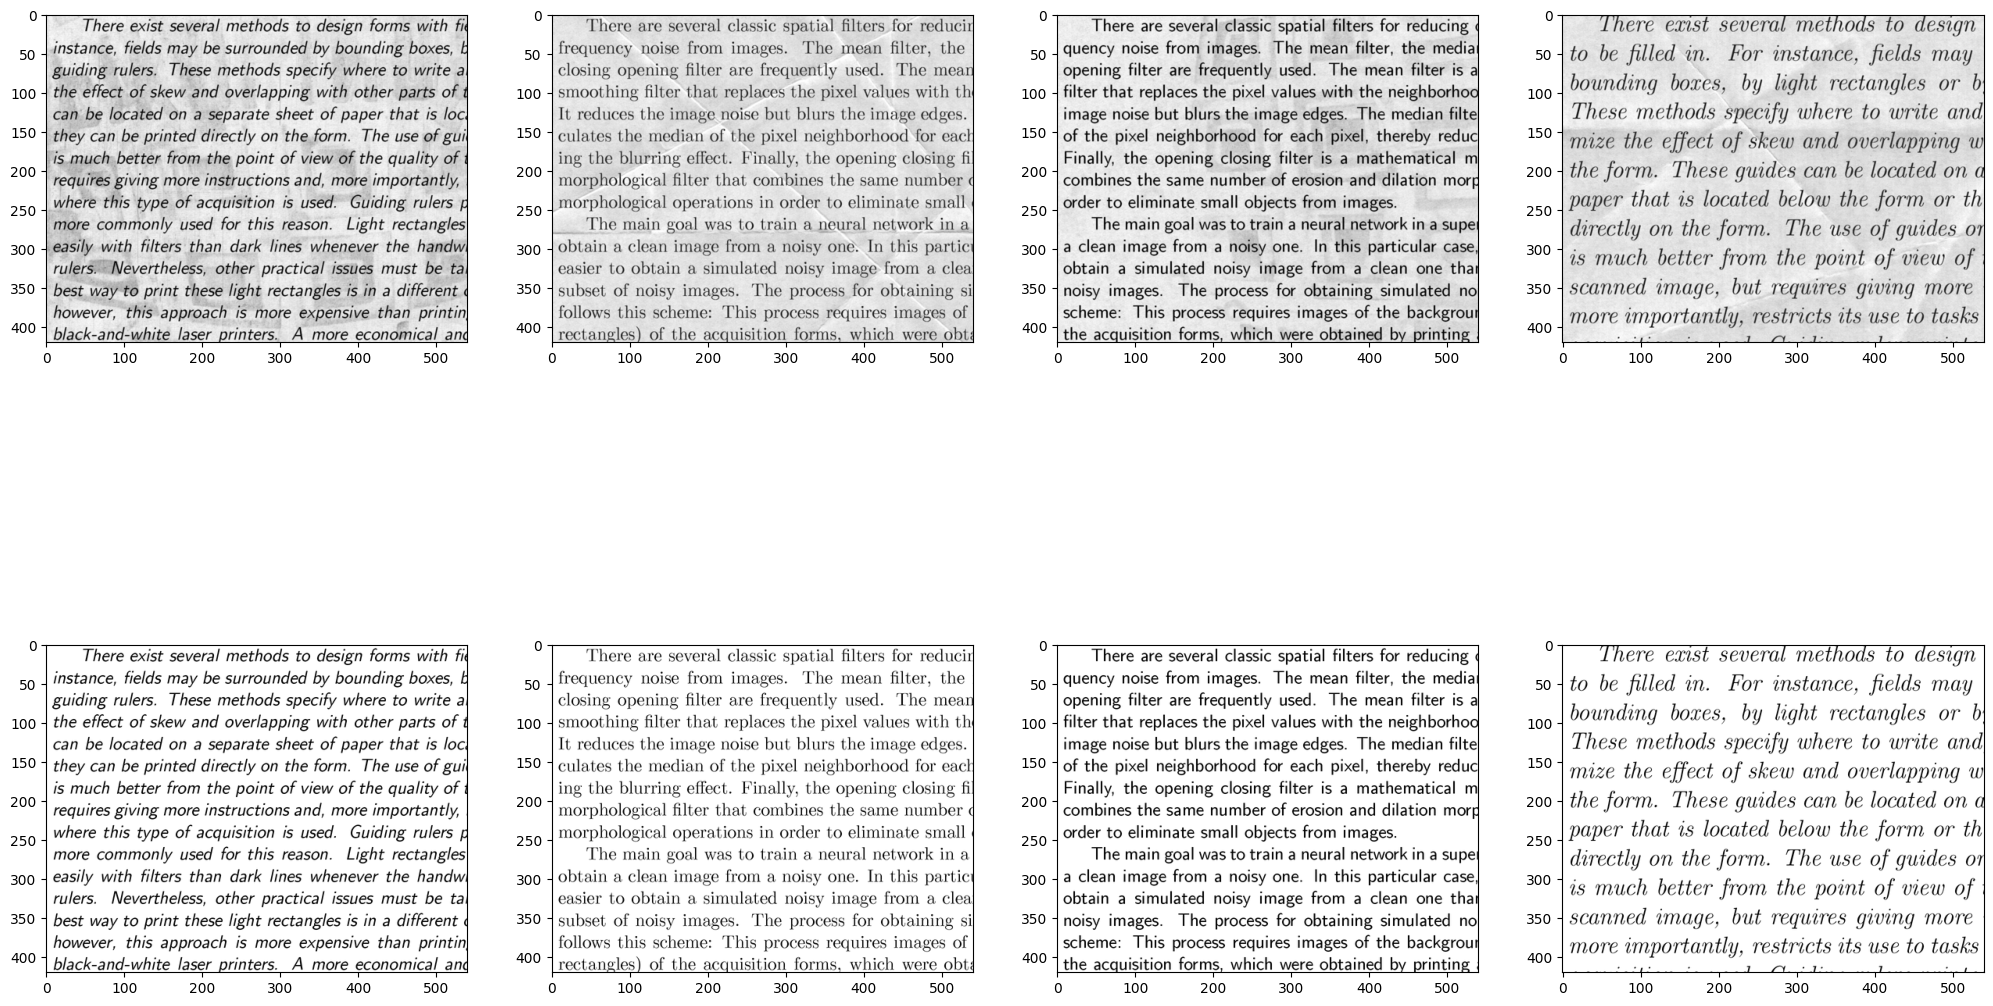

In [15]:
fig, ax = plt.subplots(2, 4, figsize=(25, 15))

for i in range(4):
    img = plt.imread(train_images[i])
    ax[0, i].imshow(img, cmap='gray')

for i in range(4):
    img = plt.imread(cleaned_images[i])
    ax[1, i].imshow(img, cmap='gray')
    
plt.show()

Let's find a small one too

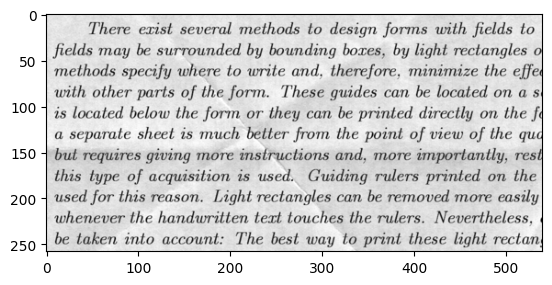

In [16]:
plt.imshow(plt.imread(train_images[100]),  cmap='gray')

### At First glance what do we see and what could we be doing ?

- there aren't that many images
- we should resize all our images to the same size -> If we cut the big images into 2 small ones, we'll increase our dataset size --> me likey data augmentation
- let's apply grayscale to all our images since it's only text 
- We should make sure that for each image we have a corresponding denoised image

-> then we can start thinking about how to denoise our images and how to train our model

### Do we have the same number of images in each set ?

In [17]:
train_images.sort() == cleaned_images.sort()

True

### RESIZING
When we get a big image, we'll want to make it into 2. Since 420 can't be divided by an int to get 258, let's be smart and keep the top 258 pixels and the bottom 258 pixels so we get 2 images of 258x540. 
Let's apply that to X_train, y_train and X_test. Also let's check again that we have a perfect X / y match


In [18]:
def split_and_save_images(images, output_folder):
    for image in images:
        img = plt.imread(image)
        if img.shape == (420, 540):
            # Split the image into two images of size 258x540
            img1 = img[0:258, :]
            img2 = img[(420-258):, :]

            filename = os.path.basename(image).split('.')[0]
            filename1 = filename + '_1.png'
            filename2 = filename + '_2.png'

            # Save the two images into the output folder
            plt.imsave(os.path.join(output_folder, filename1), img1, cmap='gray')
            plt.imsave(os.path.join(output_folder, filename2), img2, cmap='gray')
        else:
            # Save the small image into the output folder without cropping
            filename = os.path.basename(image)
            plt.imsave(os.path.join(output_folder, filename), img, cmap='gray')

split_and_save_images(train_images, 'train_resized')
split_and_save_images(cleaned_images, 'train_cleaned_resized')
split_and_save_images(test_images, 'test_resized')

### Building new lists of images from the new folders

In [19]:
train_images_resized = [os.path.join('train_resized', image) for image in os.listdir('train_resized')]
test_images_resized = [os.path.join('test_resized', image) for image in os.listdir('test_resized')]
cleaned_images_resized = [os.path.join('train_cleaned_resized', image) for image in os.listdir('train_cleaned_resized')]

In [20]:
train_images_resized.sort() == cleaned_images_resized.sort()

True

### Reshaping

(258, 540, 4)

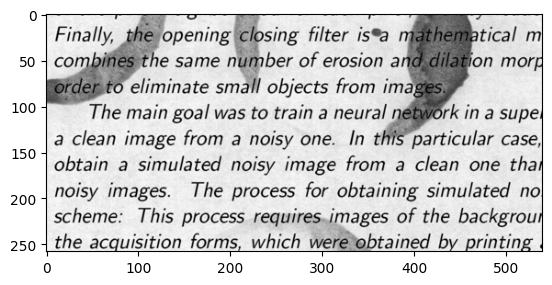

In [21]:
image_path = train_images_resized[100]
img = plt.imread(image_path)
plt.imshow(img, cmap='gray')
img.shape

It looks like there is an alpha channel sometimes in the images, let's get rid of it and build our np array 

(240, 258, 540, 1)
(120, 258, 540, 1)
(240, 258, 540, 1)


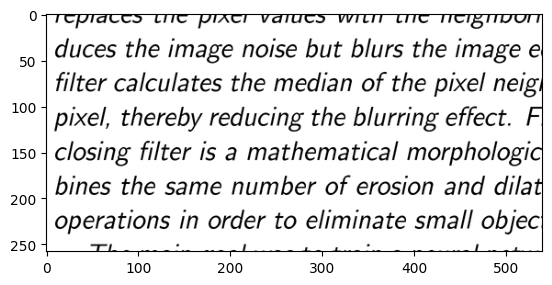

In [22]:
def process_images(image_paths):
    image_array = np.empty((len(image_paths), 258, 540, 1), dtype=np.float32)

    for i, image_path in enumerate(image_paths):
        img = plt.imread(image_path)

        if img.shape[-1] == 4:  # Check if the image has an alpha channel
            img = img[..., :3]  # Discard the alpha channel by selecting only the first three channels

        if len(img.shape) == 2:  # Check if the image is already grayscale
            gray_img = img[..., np.newaxis]  # Add a new axis to make it (height, width, 1)
        else:
            gray_img = np.mean(img, axis=2, keepdims=True)  # Convert the image to grayscale

        plt.imshow(gray_img[:, :, 0], cmap='gray')

        # Store the image in the array
        image_array[i] = gray_img
    return image_array

# Process train_images
train_array = process_images(train_images_resized)
print(train_array.shape)

# Process test_images
test_array = process_images(test_images_resized)
print(test_array.shape)

# Process cleaned_images
clean_array = process_images(cleaned_images_resized)
print(clean_array.shape)


### Let's make sure that all our images have a normalized shape

In [23]:
X_train = train_array
X_test = test_array
y_train = clean_array

X_train.shape, X_test.shape, y_train.shape

((240, 258, 540, 1), (120, 258, 540, 1), (240, 258, 540, 1))

# Let's build our model
- Since we're processing images, a CNN network seems like a good idea 
- For denoising images, an autoencoder seems like the best option.


### Autoencoder network

- loss functin is MSE since we're trying to minimize the difference between the input and the output
- Let's use the RMSE as a metric since the challenge is evaluated on it
- we'll use adam optimizer since it's the best one overall
- we could go deeper with compression for the middle layer but we'll keep it simple for now

In [24]:
def build_model():
    model = Sequential()

    # Encoder
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(258, 540, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    # Decoder
    model.add(Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same'))
    model.add(Conv2DTranspose(16, (3, 3), activation='relu', padding='same'))
    model.add(Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same'))

    model.compile(loss='mean_squared_error',
                  optimizer='adam', 
                  metrics=tf.metrics.RootMeanSquaredError())

    return model

In [25]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 258, 540, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 258, 540, 32)      4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 258, 540, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 129, 270, 64)     0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 258, 540, 32)     18464     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 258, 540, 16)     4

### We have a very reasonnable param count, let's train it !

- small batch size since we don't have that many images and we don't want to overfit
- add a patience and early stopping to stop training when we're not improving anymore
- let's go with 70/30 validation split

In [27]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3, restore_best_weights=True)

model = build_model()

history = model.fit(X_train, y_train,
                    validation_split = 0.3,
                    batch_size = 16,
                    epochs=30,
                    callbacks=[es],
                    verbose = 1)

Epoch 1/30
11/11 [==============================] - 25s 2s/step - loss: 0.1300 - root_mean_squared_error: 0.3605 - val_loss: 0.0711 - val_root_mean_squared_error: 0.2667
Epoch 2/30
11/11 [==============================] - 23s 2s/step - loss: 0.0826 - root_mean_squared_error: 0.2873 - val_loss: 0.0687 - val_root_mean_squared_error: 0.2622
Epoch 3/30
11/11 [==============================] - 24s 2s/step - loss: 0.0684 - root_mean_squared_error: 0.2615 - val_loss: 0.0580 - val_root_mean_squared_error: 0.2408
Epoch 4/30
11/11 [==============================] - 24s 2s/step - loss: 0.0575 - root_mean_squared_error: 0.2397 - val_loss: 0.0439 - val_root_mean_squared_error: 0.2095
Epoch 5/30
11/11 [==============================] - 23s 2s/step - loss: 0.0405 - root_mean_squared_error: 0.2013 - val_loss: 0.0318 - val_root_mean_squared_error: 0.1784
Epoch 6/30
11/11 [==============================] - 24s 2s/step - loss: 0.0280 - root_mean_squared_error: 0.1674 - val_loss: 0.0223 - val_root_mean_sq

### Let's plot our loss and val_loss / metric and val_metric to see how training went

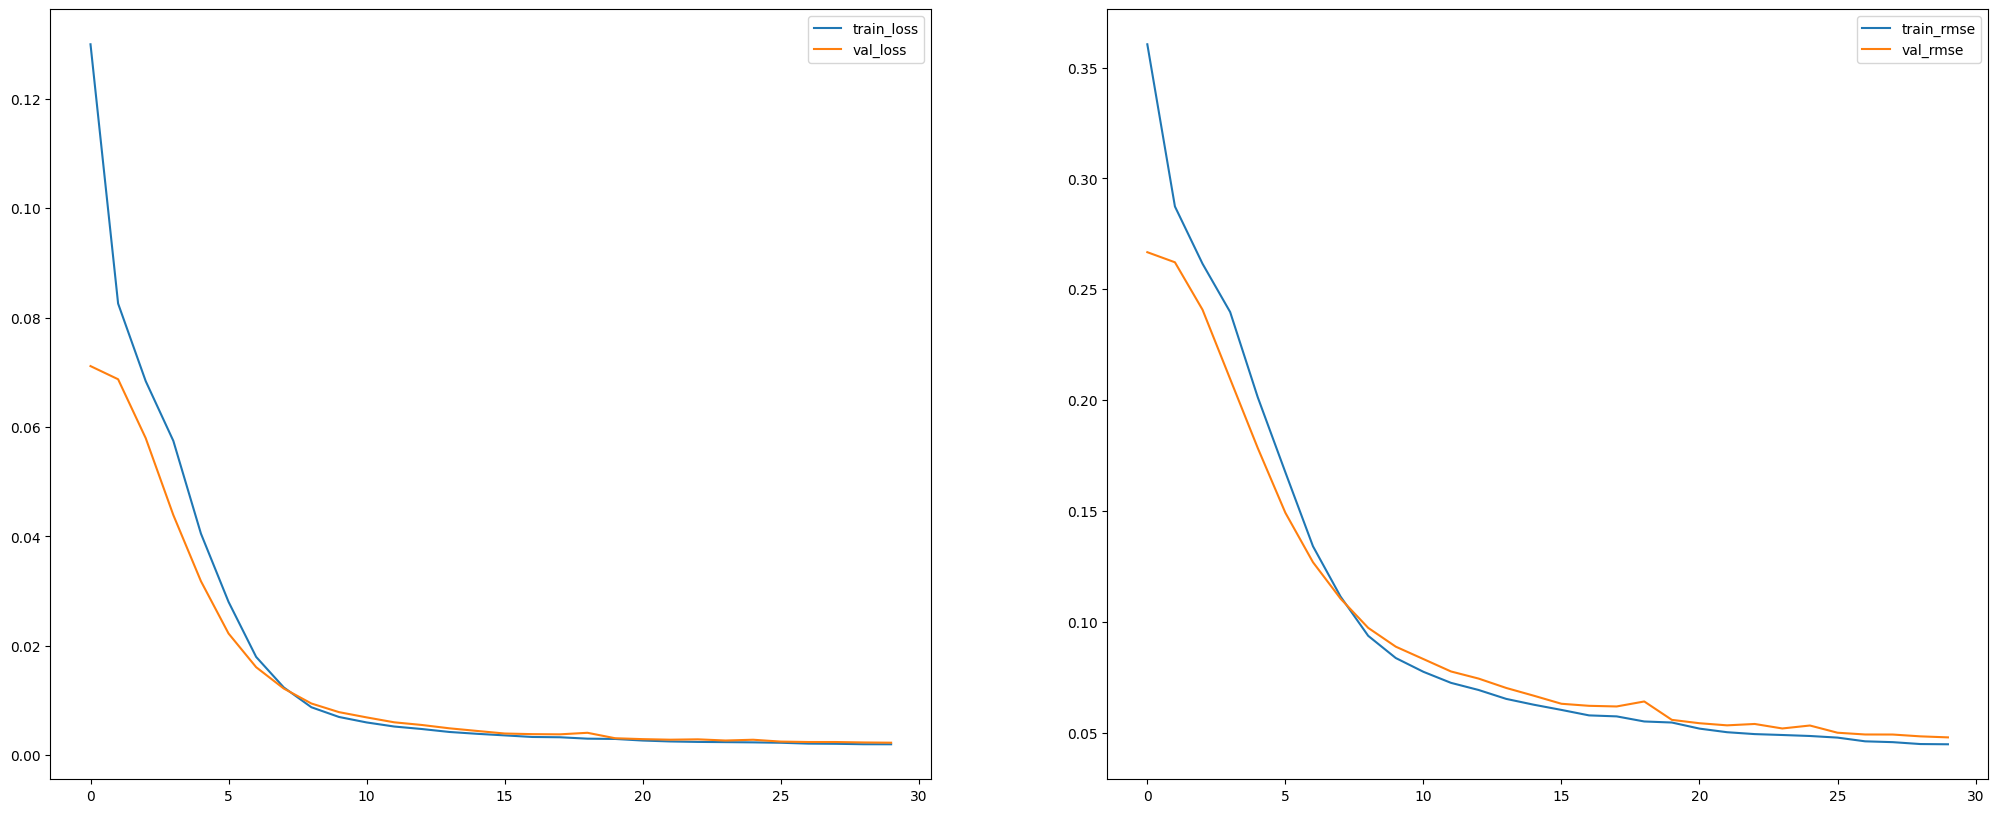

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

ax[0].plot(history.history['loss'], label='train_loss')
ax[0].plot(history.history['val_loss'], label='val_loss')
ax[0].legend()

ax[1].plot(history.history['root_mean_squared_error'], label='train_rmse')
ax[1].plot(history.history['val_root_mean_squared_error'], label='val_rmse')
ax[1].legend()

plt.show()

We've converged pretty quickly, and we can see very similar curves since mse and rmse are directly correlated. 
We have not reached our Early Stopping Criteria, but it seems like we're not improving much anymore so let's stop here.

### let's see how predictions look like when we give our model a noisy image it has never seen before !


# Predictions

4/4 [==============================] - 4s 1s/step


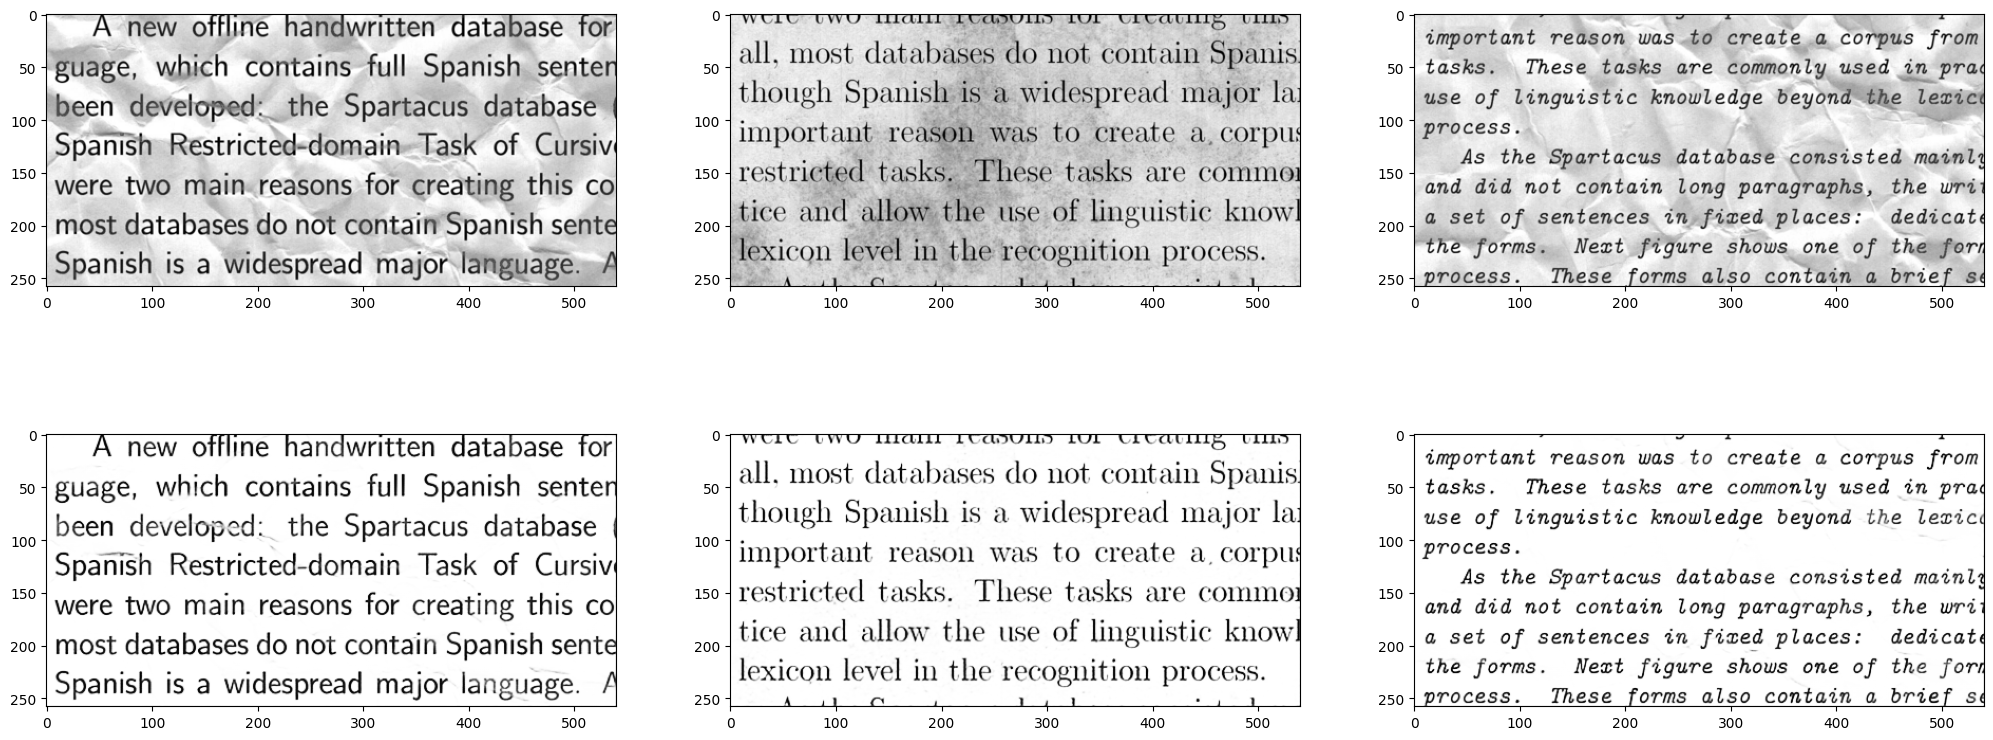

In [29]:
y_pred = model.predict(X_test)

plt.figure(figsize=(25, 10))

for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_test[i], cmap='gray')

    plt.subplot(2, 3, 3+i+1)
    plt.imshow(y_pred[i], cmap='gray')

plt.show()

It looks great !

## Let's perform ocr on the images and compare the results

In [30]:
# Reshape and squeeze the image array
resized_image = y_pred[3].squeeze()
# Normalize the pixel values to the range of 0-255
resized_image = (resized_image - np.min(resized_image)) / (np.max(resized_image) - np.min(resized_image)) * 255
# Convert to L mode == grayscale
resized_image = Image.fromarray(resized_image.astype('uint8'), mode='L')
# Perform OCR using pytesseract
text = pytesseract.image_to_string(resized_image)
print(text)

A new offline handwritten database for the Spa
contains full Spanish sentences, has recently been d
cus database (which stands for Spanish Restricted-de
Script). There were two main reasons for creating th
most databases do not contain Spanish sentences, ev
a widespread major language. Another important r¢
corpus from semantic-restricted tasks. These tasks ¢
practice and allow the use of linguistic knowledge be.
in the recognition process.




In [38]:
data = []
for i in range(10):
    # Reshape and squeeze the image array
    resized_image_X = X_test[i].squeeze()
    resized_image_y = y_pred[i].squeeze()

    # Normalize the pixel values to the range of 0-255
    resized_image_X = (resized_image_X - np.min(resized_image_X)) / (np.max(resized_image_X) - np.min(resized_image_X)) * 255
    resized_image_y = (resized_image_y - np.min(resized_image_y)) / (np.max(resized_image_y) - np.min(resized_image_y)) * 255

    # Convert to L mode (grayscale)
    resized_image_X = Image.fromarray(resized_image_X.astype('uint8'), mode='L')
    resized_image_y = Image.fromarray(resized_image_y.astype('uint8'), mode='L')

    # Perform OCR using pytesseract and replace '\n' with whitespace
    text_X = pytesseract.image_to_string(resized_image_X).replace('\n', ' ')
    text_y = pytesseract.image_to_string(resized_image_y).replace('\n', ' ')

    data.append({'X_test': text_X, 'y_pred': text_y})

df = pd.DataFrame(data)

In [47]:
# Set pandas options to display the full text in DataFrame
pd.set_option('display.max_colwidth', None)

# display the 4th row of the DataFrame as a dataframe
df

X_test  \
0                                                                                                                                                                                                     A new offline handwritten database tor guage, which contains full Spanish senten been developed:_ the Spartacus database | Spanish: Restricted-domain- Task of Cursiv were two main: reasons for creating this co most databases do not contain Spanish sente Spanish is a widespread major language.»/    
1                                                                                                                                                                                                                 NO ead es a all, most databases do not contain Spanis though Spanish is a widespread major la important reason was to create a, corpu: restricted tasks. These tasks are comme! tice and allow the use of linguistic know! lexicon level in the recognition process.  beet tae eee Re RS RY    
2                                                                                                                            important reason was.to create a corpus from tasks. These tasks are commonly used in pra use of Linguistic knowledge beyond the lexict  process.  As the Spartacus database consisted maint and did not contain long paragraphs, the wri1 a set of sentences in fired places: dedicate the forms. Next figure shows one of the forr process. These forms also contain a brief sé    
3                                                    A new offline handwritten database for the Spa contains full Spanish sentences, has recently been dc cus database (which stands for Spanish Restricted-do Script). There were two main reasons for creating th most databases do not contain Spanish sentences, ev a widespread major language. Another important r corpus from semantic-restricted tasks. These tasks ¢ practice and allow the use of linguistic knowledge be: in the recognition proc     
4                                                                                                                                                                                                                        ESE SC NESTE Se ae eee! See Bae most databases do not contain Spanish sente Spanish is a widespread major language. / reason was to create a corpus from semanti These tasks are commonly used in practice of linguistic knowledge beyond the lexicon | nition process.  ye eee eee     
5                                                                                                                                                                                                                                                                VJ Vell OU Yee £frecre were vu for creating thts corpus. First o do not contain Spanish sentences, is a widespread major language. A reason was to create a corpus fron tasks. These tasks are commonly u and allow the use of linguistic kn    
6                                                                                                                                                                                             Je a eS on eee we VEO ee all, most databases do not contain Spanis though Spanish is a widespread major la: important reason was to create a corpus restricted tasks. These tasks are commo: tice and allow the use of linguistic know] lexicon level in the recognition process.  ed ee ees ee ee eet Ae he ee    
7  A new offline handwritten database for the Spanish lai full Spanish sentences, has recently been developed: t (which stands for Spanish Restricted-domain Task of ( were two main reasons for creating this corpus. First do not contain Spanish sentences, even though Spanish language. Another important reason was to create a restricted tasks. These tasks are commonly used in prac of linguistic knowledge beyond the lexicon level in the re  As the Spartacus database consisted mainly of short    
8     

It's not overly better, but we can definitly see a slight improvement in OCR performence. Mostly, noise seems to be responsible for adding extra punctuation which we got rid of.
### Overall let's call this a success !